In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
from matplotlib import rcParams 
rcParams.update({'font.size': 18})

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [4]:
tf.__version__

'2.2.0'

In [5]:
import xarray as xr
import os

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Temperature data 

In [8]:
!ls /srv/scratch/z3289452/OceanDataScience/Mooring/PH100/ 

broken
IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc


In [33]:
# open raw netcdf file
temp = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc')

In [34]:
temp

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 688, OBSERVATION: 25570235)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S25

In [35]:
bins = [0,11,19,20,28,106,114,116]
labs = [5.5,15,19.5,24,(106-28)/2,110,115]

In [36]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [37]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs, include_lowest=True)

In [38]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1D').mean().drop(columns=['PRES']).dropna()

In [39]:
temp_df.groupby('PRES_BIN').count()

,TEMP
PRES_BIN,
5.5,284
15.0,1722
19.5,115
24.0,358
39.0,16
110.0,2802
115.0,105


Based on the binning above, three models will be trained: 15 dbar, 24 dbar and 110 dbar.

### 15 dbar

In [40]:
temp_df_15 = temp_df.xs(15)

In [14]:
temp_df_15

,TEMP
TIME,
2011-03-30,23.995378
2011-03-31,23.710236
2011-04-01,23.333200
2011-04-02,22.781210
2011-04-03,22.811733
...,...
2017-08-23,17.224247
2017-08-24,17.473562
2017-08-25,17.870966


In [54]:
clim = temp_df_15.groupby([temp_df_15.index.month, temp_df_15.index.day]).mean()
clim = clim.TEMP.rolling(15).mean()
clim.index = np.arange(1, len(clim)+1, 1)

Text(0, 0.5, 'Temperature (degrees celsius)')

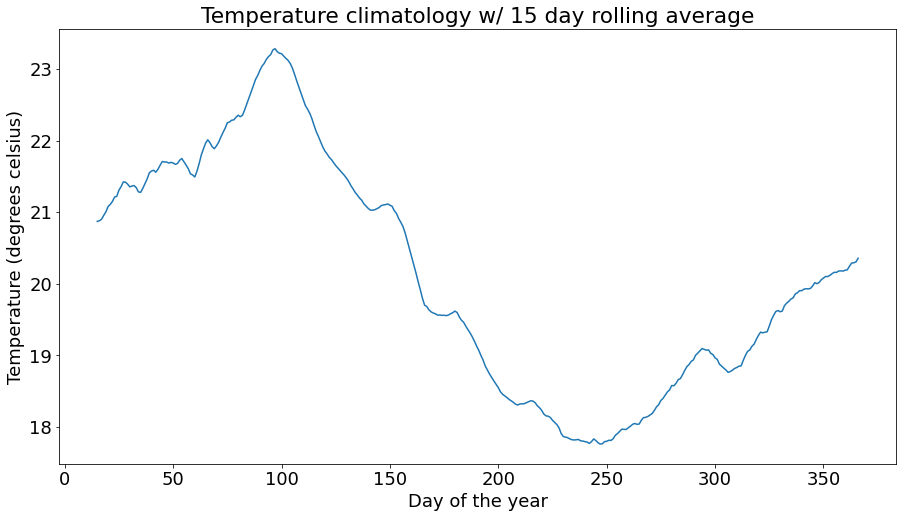

In [56]:
plt.figure(figsize=(15,8))
plt.plot(clim.index, clim)
plt.title("Temperature climatology w/ 15 day rolling average")
plt.xlabel("Day of the year")
plt.ylabel("Temperature (degrees celsius)")

In [75]:
temp_df_15_wgaps = temp_df_15.copy()
temp_df_15_wgaps = temp_df_15_wgaps.asfreq(freq='1D')

In [76]:
temp_df_15_wgaps

,TEMP
TIME,
2011-03-30,23.995378
2011-03-31,23.710236
2011-04-01,23.333200
2011-04-02,22.781210
2011-04-03,22.811733
...,...
2017-08-23,17.224247
2017-08-24,17.473562
2017-08-25,17.870966


Text(0.5, 0, 'Time (years)')

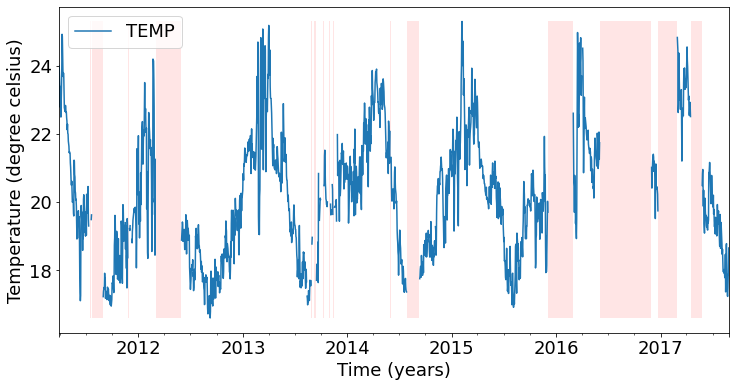

In [17]:
fig, ax = plt.subplots()
import matplotlib.transforms as mtransforms
temp_df_15_wgaps.plot(ax = ax, figsize=(12,6))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(temp_df_15_wgaps.index, temp_df_15_wgaps.TEMP.min(), temp_df_15_wgaps.TEMP.max(), where=np.isnan(temp_df_15_wgaps.TEMP),
                facecolor='red', alpha=0.1)
plt.ylabel("Temperature (degree celsius)")
plt.xlabel("Time (years)")

In [41]:
# !!Important!! Run this code
Time_diff = temp_df_15.index.to_series().diff()

#### Model

In [42]:
class descaled_mape(keras.losses.Loss):
    """
    A loss/metric that (de)scales true and predicted values into absolute units before calculating mean absolute percentage error (mape).
    Args:
        mu: mean (usually training data mean)
        sd: standard dev (usually based on training data)
        reduction: Type of tf.keras.losses.Reduction to apply to loss.
        name: name of loss function
    """
    def __init__(self, mu, sd, reduction=keras.losses.Reduction.AUTO, name='descaled_mape'):
        super().__init__(reduction=reduction, name=name)
        self.mu=mu
        self.sd=sd
    
    def call(self, y_true, y_pred):
        y_true = y_true * self.sd + self.mu
        y_pred = y_pred * self.sd + self.mu
        return tf.math.reduce_mean(tf.abs((y_true - y_pred)/y_true))

In [10]:
# load histories of all 3 models and plot training curves
# model 1 hist: 30 targ: 10 
pickle_in = open("../data/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ10_loss-descaledmape_earlystopping_history.pickle", "rb")
hist1 = pickle.load(pickle_in)
pickle_in.close()
hist1["epoch"] = hist1.index + 1
# model 2 hist: 91 targ: 91 
pickle_in = open("../data/temp_gapfilling_daily_bidirectional_lstm_model_hist91_targ91_loss-descaledmape_Earlystopping_history.pickle", "rb")
hist2 = pickle.load(pickle_in)
pickle_in.close()
hist2["epoch"] = hist2.index + 1
# model 3 hist: 181 targ: 181 
pickle_in = open("../data/temp_gapfilling_daily_bidirectional_lstm_model_hist181_targ181_loss-descaledmape_100Epochs_history.pickle", "rb")
hist3 = pickle.load(pickle_in)
pickle_in.close()
hist3["epoch"] = hist3.index + 1

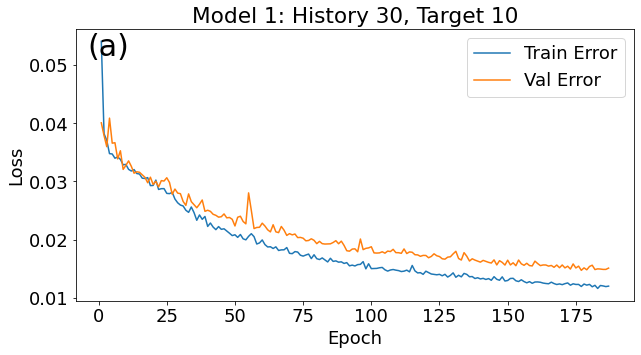

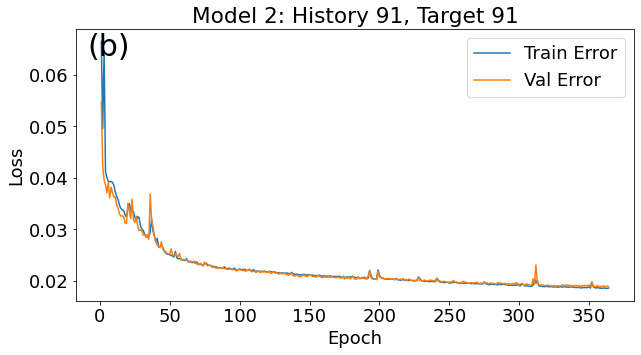

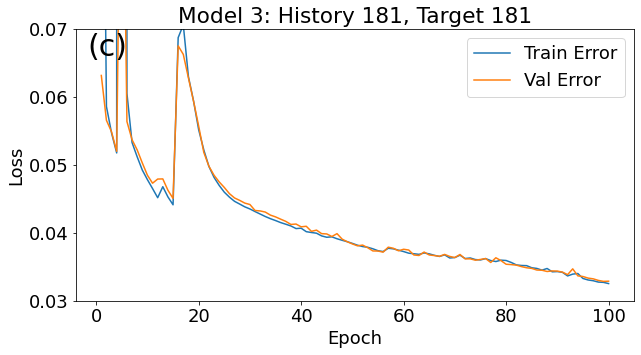

In [21]:
# Now plot training curves
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1: History 30, Target 10')
plt.plot(hist1['epoch'], hist1['descaled_mape'],
         label='Train Error')
plt.plot(hist1['epoch'], hist1['val_descaled_mape'],
         label = 'Val Error')
plt.text(0.02,0.9,"(a)",transform=ax.transAxes, fontsize=30)
plt.legend()

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2: History 91, Target 91')
plt.plot(hist2['epoch'], hist2['descaled_mape'],
         label='Train Error')
plt.plot(hist2['epoch'], hist2['val_descaled_mape'],
         label = 'Val Error')
plt.text(0.02,0.9,"(b)",transform=ax.transAxes, fontsize=30)
plt.legend()

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3: History 181, Target 181')
plt.plot(hist3['epoch'], hist3['descaled_mape'],
         label='Train Error')
plt.plot(hist3['epoch'], hist3['val_descaled_mape'],
         label = 'Val Error')
plt.text(0.02,0.9,"(c)",transform=ax.transAxes, fontsize=30)
plt.ylim([0.03,0.07])
plt.legend()

plt.show()

#### Bidirectional tri-layer LSTM model with 10 target time-steps

In [43]:
hist_len = 30
targ_len = 10

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15))
window_len = hist_len + targ_len

In [44]:
data = []
labels = []

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15.values[indices], (hist_len,1)))
        labels.append(temp_df_15.values[i:i+targ_len])
        
data = np.array(data)
labels = np.array(labels)

In [45]:
data.shape, labels.shape

((1044, 30, 1), (1044, 10, 1))

In [46]:
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
train_labels = train_labels.reshape((len(train_labels),targ_len))
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)
val_labels = val_labels.reshape((len(val_labels), targ_len))

In [47]:
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()

In [48]:
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

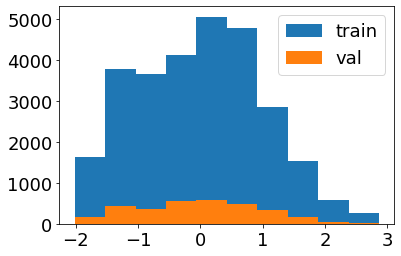

In [49]:
plt.hist(train_data.flatten(), label='train'),plt.hist(val_data.flatten(), label='val')
plt.legend()

In [50]:
BATCH_SIZE = 8
BUFFER_SIZE = data.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [27]:
bidirectional_lstm_targ10_model = tf.keras.models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:])),
    layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True,)),
    layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')),
    tf.keras.layers.Dense(10)
])

bidirectional_lstm_targ10_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])


In [119]:
# check output shape of model
bidirectional_lstm_targ10_model.predict(val_univariate.take(1)).shape

(8, 10)

In [120]:
checkpoint_path = "../data/bidirectional_lstm_daily_hist30_targ10_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [121]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 200

history = bidirectional_lstm_targ10_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot()])

loss:  0.0571, val_loss:  0.0387
..........loss:  0.0317, val_loss:  0.0322
..........loss:  0.0306, val_loss:  0.0309
..........loss:  0.0263, val_loss:  0.0277
..........loss:  0.0239, val_loss:  0.0259
..........loss:  0.0236, val_loss:  0.0244
..........loss:  0.0198, val_loss:  0.0213
..........loss:  0.0174, val_loss:  0.0188
..........loss:  0.0166, val_loss:  0.0188
..........loss:  0.0161, val_loss:  0.0178
..........loss:  0.0149, val_loss:  0.0174
..........loss:  0.0145, val_loss:  0.0170
..........loss:  0.0144, val_loss:  0.0171
..........loss:  0.0133, val_loss:  0.0171
..........loss:  0.0129, val_loss:  0.0158
..........loss:  0.0124, val_loss:  0.0158
..........loss:  0.0122, val_loss:  0.0155
..........loss:  0.0116, val_loss:  0.0157
..........loss:  0.0120, val_loss:  0.0148
..........loss:  0.0116, val_loss:  0.0141
..........

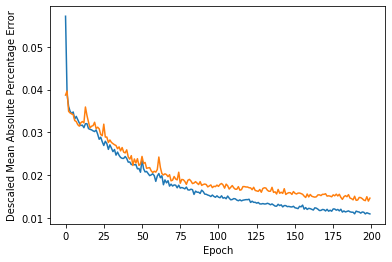

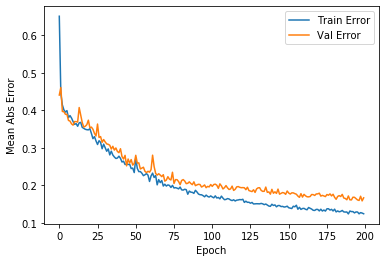

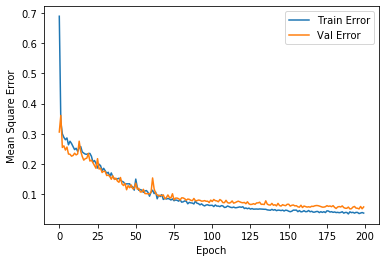

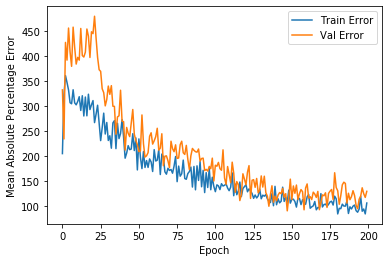

In [122]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Descaled Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['descaled_mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_descaled_mape'],
           label = 'Val Error')
#   plt.ylim([0.9,
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [26]:
## Save model
bidirectional_lstm_targ10_model.save('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ10_loss-descaledmape.h5')

NameError: name 'bidirectional_lstm_targ10_model' is not defined

In [29]:
#load model if already trained
bidirectional_lstm_targ10_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ10_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ10_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

In [30]:
bidirectional_lstm_targ10_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection multiple                  33792     
_________________________________________________________________
bidirectional_5 (Bidirection multiple                  41216     
_________________________________________________________________
bidirectional_6 (Bidirection multiple                  4672      
_________________________________________________________________
dense_2 (Dense)              multiple                  170       
Total params: 79,850
Trainable params: 79,850
Non-trainable params: 0
_________________________________________________________________


In [54]:
# load model 1
# first load train and test data and standardization
pickle_in = open("../data/train_mean-std_train-val_data-labels_hist30_targ10.pickle", "rb")
data = pickle.load(pickle_in)
train_mean = data[0]
train_std = data[1]
train_data = (data[2]-train_mean)/train_std
train_labels = (data[3]-train_mean)/train_std
val_data = (data[4]-train_mean)/train_std
val_labels = (data[5]-train_mean)/train_std
pickle_in.close()
# Now load model. !!Run descaled_mape cell before!!
bidirectional_lstm_targ10_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ10_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ10_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

In [55]:
train_data.mean(), train_mean, train_std

(-2.8786084e-07, 20.156157, 1.7749674)

In [56]:
BATCH_SIZE = 8
BUFFER_SIZE = train_data.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [57]:
def create_time_steps(length):
  return list(range(-length, 0))

In [70]:
def multi_step_plot(history, true_future, prediction, lab):
  fig, ax = plt.subplots(figsize=(10, 5))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.text(0.9,0.9,lab,transform=ax.transAxes,fontsize=30)

In [69]:
for x in zip(val_univariate.take(1), ["a"]):
    print(x[0][0][0])
    print(x[0][1][0])
    print(x[1])

tf.Tensor(
[[1.4789305]
 [1.496127 ]
 [1.8210431]
 [1.3156434]
 [1.5438986]
 [1.8018446]
 [2.1021302]
 [2.684902 ]
 [2.647095 ]
 [2.347006 ]
 [2.0830154]
 [1.9860442]
 [2.045433 ]
 [1.9888284]
 [1.6781881]
 [1.4715395]
 [1.4455819]
 [1.408266 ]
 [1.4212608]
 [1.5078013]
 [1.4504379]
 [1.3908287]
 [1.395501 ]
 [1.3028666]
 [1.2498962]
 [1.1053712]
 [1.1986235]
 [1.0460006]
 [1.0348228]
 [0.9155807]], shape=(30, 1), dtype=float32)
tf.Tensor(
[0.8732894  0.83342993 0.72582126 0.74300706 0.7226942  0.719406
 0.5553624  0.48140967 0.35141098 0.20652828], shape=(10,), dtype=float32)
a


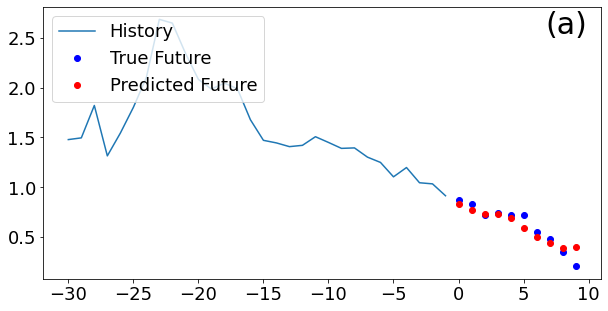

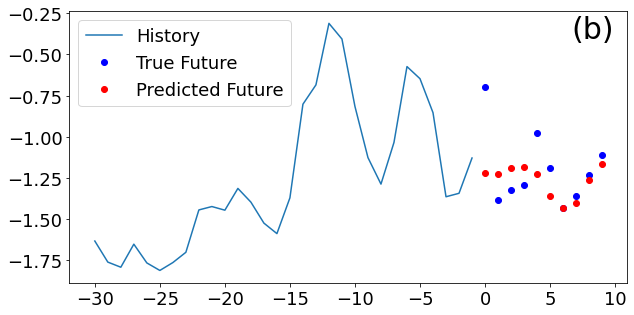

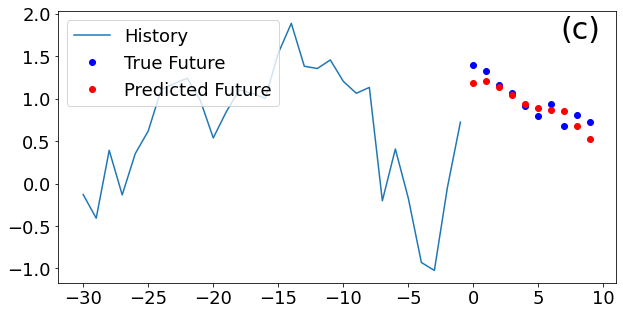

In [73]:
for x, lab in zip(val_univariate.take(3), ["(a)", "(b)", "(c)"]):
  multi_step_plot(x[0][0], x[1][0], bidirectional_lstm_targ10_model.predict(x[0])[0], lab)

### Compare with interpolation

In [39]:
def gap_loc_and_len(sample):
    tmp = 0
    loc = []
    leng = []
    for i in range(len(sample)):
        current=sample[i]
        if not(np.isnan(current)) and tmp>0:
            leng.append(tmp)
            tmp=0
        if np.isnan(current):
            if (tmp==0) : loc.append(i)
            tmp=tmp+1
    df = pd.DataFrame({'location': loc,
                       'length': leng})
    return(df)

In [32]:
gaps = gap_loc_and_len(temp_df_15_wgaps.TEMP.values)

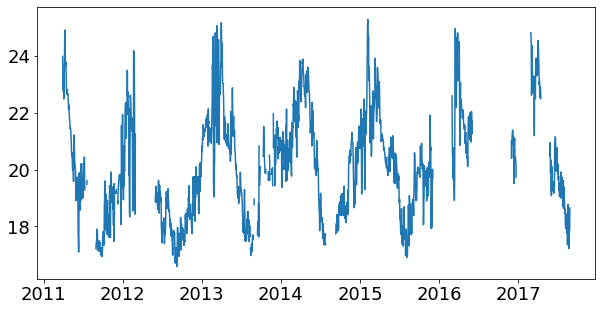

In [79]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_wgaps.index, temp_df_15_wgaps.TEMP)

In [37]:
def gapfill(samp, lstm_model, train_mean, train_std, hist_len, pred_len):
    gaps = gap_loc_and_len(samp.TEMP)
    for i in range(len(gaps)):
        gap_start = gaps.location[i]
        gap_length = gaps.length[i]
        hist_end = gap_start
        if gap_start < hist_len:
            hist_start = 0
        else:
            hist_start = gap_start - hist_len
        if ((gap_start >= hist_len) and (not np.any(np.isnan(samp.TEMP[hist_start: hist_end]))) and (gap_length <= pred_len)):
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(samp.TEMP.values[:gap_start][-hist_len:], (1,hist_len,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = lstm_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            samp.TEMP[gap_start : (gap_start + gap_length)] = out
    return samp

In [35]:
temp_df_15_filled = temp_df_15_wgaps.copy()
temp_df_15_filled = gapfill(temp_df_15_filled, bidirectional_lstm_targ10_model, train_mean, train_std, 30, 10)

In [36]:
gaps

,location,length
0,104,1
1,106,1
2,108,4
3,114,40
4,230,1
5,235,1
6,241,5
7,249,1
8,251,1
9,253,1


In [37]:
gap_loc_and_len(temp_df_15_filled.TEMP)

,location,length
0,114,40
1,337,91
2,1216,45
3,1710,88
4,1891,181
5,2095,67
6,2209,40


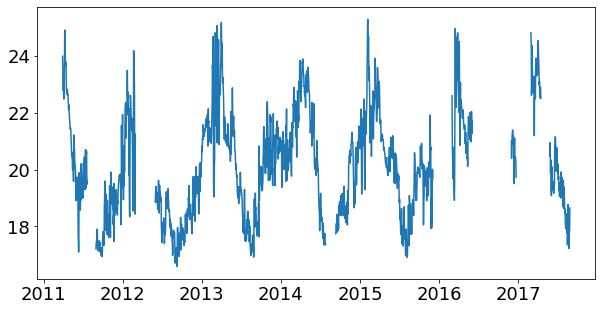

In [38]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled.index, temp_df_15_filled.TEMP)

In [39]:
temp_df_15_filled

,TEMP
TIME,
2011-03-30,23.995378
2011-03-31,23.710236
2011-04-01,23.333200
2011-04-02,22.781210
2011-04-03,22.811733
...,...
2017-08-23,17.224247
2017-08-24,17.473562
2017-08-25,17.870966


## Three month prediction model

#### Bidirectional tri-layer LSTM model with 91 target time-steps

In [40]:
temp_df_15_filled.dropna(inplace=True)

In [41]:
# !!Important!! Run this code
Time_diff = temp_df_15_filled.index.to_series().diff()

In [42]:
hist_len = 182
targ_len = 91

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15_filled))
window_len = hist_len + targ_len

In [46]:
data = []
labels = []

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15.values[indices], (hist_len,1)))
        labels.append(temp_df_15.values[i:i+targ_len])
        
data = np.array(data)
labels = np.array(labels)

In [47]:
data.shape, labels.shape

((689, 182, 1), (689, 91, 1))

In [48]:
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
train_labels = train_labels.reshape((len(train_labels),targ_len))
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)
val_labels = val_labels.reshape((len(val_labels), targ_len))

In [49]:
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()

In [50]:
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

In [44]:
import pickle

In [52]:
pickle_out = open("../data/train_mean-std_train-val_data-labels_hist182_targ91.pickle", "wb")
pickle.dump([train_mean, train_std, train_data, train_labels, val_data, val_labels], pickle_out)
pickle_out.close()

In [45]:
pickle_in = open("../data/train_mean-std_train-val_data-labels_hist182_targ91.pickle", "rb")
data = pickle.load(pickle_in)
train_mean = data[0]
train_std = data[1]
train_data = data[2]
train_labels = data[3]
val_data = data[4]
val_labels = data[5]
pickle_in.close()

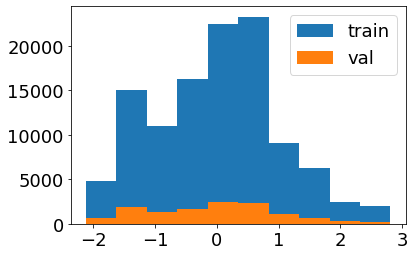

In [46]:
plt.hist(train_data.flatten(), label='train'),plt.hist(val_data.flatten(), label='val')
plt.legend()

In [169]:
BATCH_SIZE = 8
BUFFER_SIZE = data.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [170]:
bidirectional_lstm_targ91_model = tf.keras.models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:])),
    layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True,)),
    layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')),
    tf.keras.layers.Dense(91)
])

bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])


In [171]:
# check output shape of model
bidirectional_lstm_targ91_model.predict(val_univariate.take(1)).shape

(8, 91)

In [172]:
checkpoint_path = "../data/bidirectional_lstm_daily_hist182_targ91_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [ ]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 500

history = bidirectional_lstm_targ91_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot()])

loss:  0.0704, val_loss:  0.0640
......

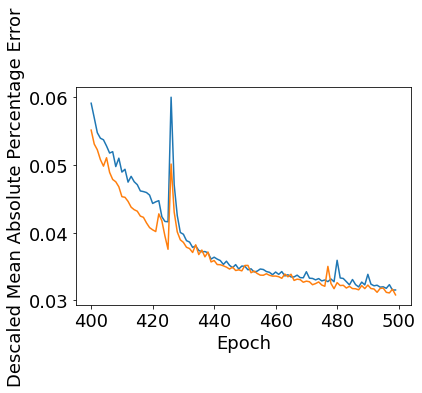

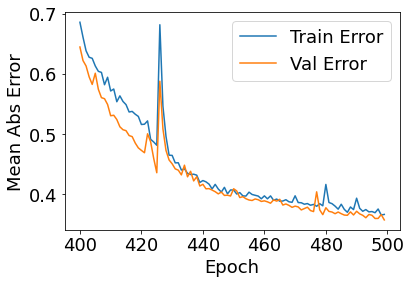

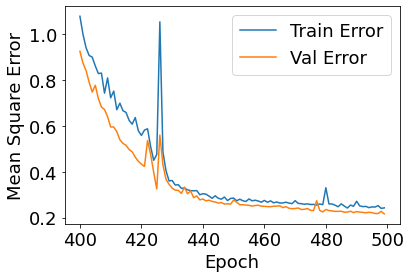

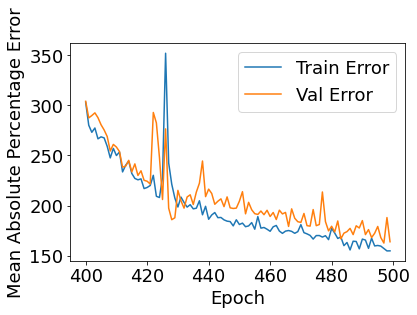

In [194]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist = hist.loc[400:]
  hist['epoch'] = history.epoch[400:]

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Descaled Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['descaled_mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_descaled_mape'],
           label = 'Val Error')
#   plt.ylim([0.9,
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [178]:
history_df = pd.DataFrame(history.history)

In [195]:
history_df

,loss,descaled_mape,mae,mse,mean_absolute_percentage_error,val_loss,val_descaled_mape,val_mae,val_mse,val_mean_absolute_percentage_error
0,0.070353,0.070353,0.803220,0.990456,122.822723,0.064005,0.064005,0.730314,0.832586,162.544418
1,0.055904,0.055965,0.643392,0.671442,196.682846,0.044004,0.044004,0.514031,0.437443,245.921021
2,0.041187,0.041241,0.479311,0.394542,199.728088,0.036578,0.036578,0.423521,0.297084,224.621750
3,0.045770,0.045649,0.520390,6.814305,191.117020,0.040998,0.040998,0.474723,0.358387,192.466995
4,0.037831,0.037847,0.439691,0.333225,203.724182,0.034483,0.034483,0.401237,0.266580,197.114838
...,...,...,...,...,...,...,...,...,...,...
495,0.032036,0.032018,0.371461,0.246492,160.096481,0.031835,0.031835,0.365284,0.221461,179.074738
496,0.031825,0.031796,0.369541,0.245663,159.474014,0.031204,0.031204,0.359967,0.217748,167.983276
497,0.032350,0.032338,0.375685,0.251886,157.078400,0.031116,0.031116,0.360060,0.217446,162.519531
498,0.031514,0.031541,0.365719,0.239845,154.658585,0.031672,0.031672,0.366422,0.227006,187.956024


In [196]:
## Save model
bidirectional_lstm_targ91_model.save('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist182_targ91_loss-descaledmape_500epochs.h5')

In [198]:
## Save History
import pickle
pickle_out = open("../data/temp_gapfilling_daily_bidirectional_lstm_model_hist182_targ91_loss-descaledmape_500epochs_history.pickle", "wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [47]:
#load model if already trained
bidirectional_lstm_targ91_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist182_targ91_loss-descaledmape_500epochs.h5', compile=False)
bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

In [50]:
bidirectional_lstm_targ91_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection multiple                  33792     
_________________________________________________________________
bidirectional_7 (Bidirection multiple                  41216     
_________________________________________________________________
bidirectional_8 (Bidirection multiple                  4672      
_________________________________________________________________
dense_2 (Dense)              multiple                  1547      
Total params: 81,227
Trainable params: 81,227
Non-trainable params: 0
_________________________________________________________________


In [48]:
#load history
pickle_in = open("../data/temp_gapfilling_daily_bidirectional_lstm_model_hist182_targ91_loss-descaledmape_500epochs_history.pickle", "rb")
history = pd.DataFrame(pickle.load(pickle_in))

In [49]:
history

,loss,descaled_mape,mae,mse,mean_absolute_percentage_error,val_loss,val_descaled_mape,val_mae,val_mse,val_mean_absolute_percentage_error
0,0.070353,0.070353,0.803220,0.990456,122.822723,0.064005,0.064005,0.730314,0.832586,162.544418
1,0.055904,0.055965,0.643392,0.671442,196.682846,0.044004,0.044004,0.514031,0.437443,245.921021
2,0.041187,0.041241,0.479311,0.394542,199.728088,0.036578,0.036578,0.423521,0.297084,224.621750
3,0.045770,0.045649,0.520390,6.814305,191.117020,0.040998,0.040998,0.474723,0.358387,192.466995
4,0.037831,0.037847,0.439691,0.333225,203.724182,0.034483,0.034483,0.401237,0.266580,197.114838
...,...,...,...,...,...,...,...,...,...,...
495,0.032036,0.032018,0.371461,0.246492,160.096481,0.031835,0.031835,0.365284,0.221461,179.074738
496,0.031825,0.031796,0.369541,0.245663,159.474014,0.031204,0.031204,0.359967,0.217748,167.983276
497,0.032350,0.032338,0.375685,0.251886,157.078400,0.031116,0.031116,0.360060,0.217446,162.519531
498,0.031514,0.031541,0.365719,0.239845,154.658585,0.031672,0.031672,0.366422,0.227006,187.956024


In [59]:
temp_df_15_filled = temp_df_15_filled.asfreq(freq="1D")

In [141]:
gaps = gap_loc_and_len(temp_df_15_filled.TEMP.values)
gaps

,location,length
0,114,40
1,337,91
2,1216,45
3,1710,88
4,1891,181
5,2095,67
6,2209,40


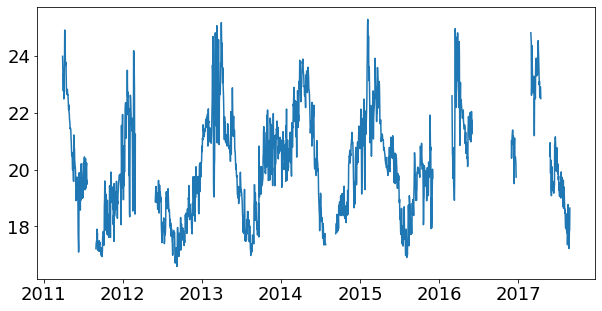

In [148]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled.index, temp_df_15_filled.TEMP)

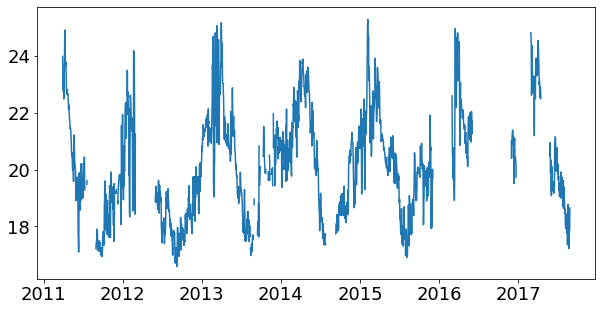

In [143]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_wgaps.index, temp_df_15_wgaps.TEMP)

In [144]:
def gapfill(samp, lstm_model, train_mean, train_std):
    gaps = gap_loc_and_len(samp.TEMP)
    for i in range(len(gaps)):
        gap_start = gaps.location[i]
        gap_length = gaps.length[i]
        hist_end = gap_start
        if gap_start < 182:
            hist_start = 0
        else:
            hist_start = gap_start - 182
        if ((gap_start >= 182) and (not np.any(np.isnan(samp.TEMP[hist_start: hist_end]))) and (gap_length <= 91)):
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(samp.TEMP.values[:gap_start][-182:], (1,182,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = bidirectional_lstm_targ91_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            samp.TEMP[gap_start : (gap_start + gap_length)] = out
    return samp

In [145]:
temp_df_15_filled_2 = temp_df_15_filled.copy()
temp_df_15_filled_2 = gapfill(temp_df_15_filled_2, bidirectional_lstm_targ91_model, train_mean, train_std)

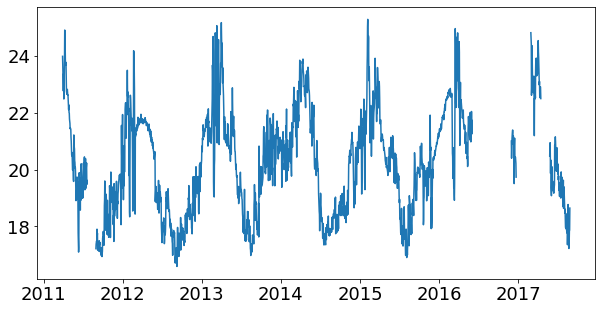

In [146]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled_2.index, temp_df_15_filled_2.TEMP)

In [147]:
gap_loc_and_len(temp_df_15_filled.TEMP)

,location,length
0,114,40
1,337,91
2,1216,45
3,1710,88
4,1891,181
5,2095,67
6,2209,40


In [83]:
# what does it look like when all gaps are recursively filled by this model?
def recursive_gapfill(sample, lstm_model, train_mean, train_std):
    """
    Function to fill gaps in a timeseries with a LSTM RNN model
    Args:
        sample: A numpy array of timeseries with gaps represented by NaNs
        lstm_model: A model trained on the entire sample dataset for gap-filling
        train_mean: the mean value to de(re)scale model output with
        train_std: sd to de(re)scale model output with
    """
    
    while np.any(np.isnan(sample)):
        # find the first NaN
        gap_start = np.min(np.argwhere(np.isnan(sample))) 
        if gap_start < 182:
            print('Error: There must be atleast 30 non nan values before the first gap for the prediction to work.')
            break
        else:
            # find gap length
            gap_length = np.min(np.argwhere(~np.isnan(sample[gap_start:])))
            if gap_length > 91:
                gap_length = 91
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(sample[:gap_start][-182:], (1,182,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = lstm_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            sample[gap_start : (gap_start + gap_length)] = out
        
    return sample

In [149]:
temp_df_15_filled_2 = temp_df_15_filled.copy()
temp_df_15_filled_2 = recursive_gapfill(temp_df_15_filled_2.TEMP.values[154:], bidirectional_lstm_targ91_model, train_mean, train_std)

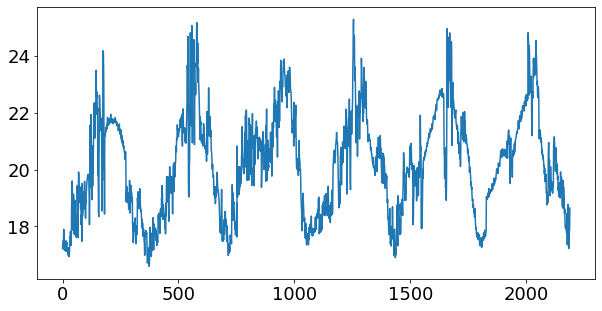

In [152]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled_2)

## Use only 91 day history to predict 91 days to bring back some variability

In [40]:
temp_df_15_filled.dropna(inplace=True)

In [57]:
# !!Important!! Run this code
Time_diff = temp_df_15_filled.index.to_series().diff()

In [58]:
hist_len = 91
targ_len = 91

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15_filled))
window_len = hist_len + targ_len

In [59]:
data = []
labels = []

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15_filled.values[indices], (hist_len,1)))
        labels.append(temp_df_15_filled.values[i:i+targ_len])
        
data = np.array(data)
labels = np.array(labels)

In [60]:
data.shape, labels.shape

((871, 91, 1), (871, 91, 1))

In [46]:
temp_df_15_filled.TEMP

TIME
2011-03-30    23.995378
2011-03-31    23.710236
2011-04-01    23.333200
2011-04-02    22.781210
2011-04-03    22.811733
                ...    
2017-08-23    17.224247
2017-08-24    17.473562
2017-08-25    17.870966
2017-08-26    17.871325
2017-08-27    18.647106
Name: TEMP, Length: 1791, dtype: float32

In [158]:
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
train_labels = train_labels.reshape((len(train_labels),targ_len))
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)
val_labels = val_labels.reshape((len(val_labels), targ_len))

In [159]:
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()

In [160]:
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

In [40]:
import pickle

In [162]:
pickle_out = open("../data/train_mean-std_train-val_data-labels_hist91_targ91.pickle", "wb")
pickle.dump([train_mean, train_std, train_data, train_labels, val_data, val_labels], pickle_out)
pickle_out.close()

In [106]:
pickle_in = open("../data/train_mean-std_train-val_data-labels_hist91_targ91.pickle", "rb")
data = pickle.load(pickle_in)
train_mean = data[0]
train_std = data[1]
train_data = data[2]
train_labels = data[3]
val_data = data[4]
val_labels = data[5]
pickle_in.close()

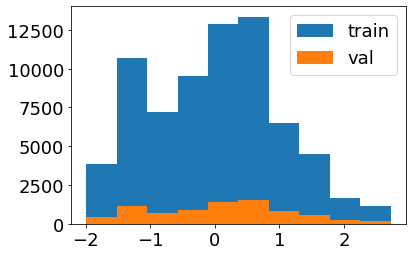

In [42]:
plt.hist(train_data.flatten(), label='train'),plt.hist(val_data.flatten(), label='val')
plt.legend()

In [62]:
BATCH_SIZE = 8
BUFFER_SIZE = train_data.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [63]:
bidirectional_lstm_targ91_model = tf.keras.models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:])),
    layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True,)),
    layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')),
    tf.keras.layers.Dense(91)
])

bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])


In [64]:
# check output shape of model
bidirectional_lstm_targ91_model.predict(val_univariate.take(1)).shape

(8, 91)

In [70]:
checkpoint_path = "../data/bidirectional_lstm_daily_hist182_targ91_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [71]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 1000

history = bidirectional_lstm_targ91_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot(), es_callback])

loss:  0.0271, val_loss:  0.0246
..........loss:  0.0275, val_loss:  0.0233
..........loss:  0.0238, val_loss:  0.0219
..........loss:  0.0230, val_loss:  0.0210
..........loss:  0.0227, val_loss:  0.0207
..........loss:  0.0219, val_loss:  0.0205
..........loss:  0.0218, val_loss:  0.0198
..........loss:  0.0216, val_loss:  0.0196
..........loss:  0.0213, val_loss:  0.0192
..........loss:  0.0208, val_loss:  0.0191
..........loss:  0.0205, val_loss:  0.0190
..........loss:  0.0203, val_loss:  0.0183
..........loss:  0.0201, val_loss:  0.0185
..........loss:  0.0200, val_loss:  0.0184
..........loss:  0.0196, val_loss:  0.0179
..........loss:  0.0196, val_loss:  0.0177
.....

In [76]:
history_df = pd.concat([history_df, pd.DataFrame(history.history)])
history_df

,loss,descaled_mape,mae,mse,mean_absolute_percentage_error,val_loss,val_descaled_mape,val_mae,val_mse,val_mean_absolute_percentage_error
0,0.063758,0.063758,0.705335,0.852042,178.581177,0.054472,0.054472,0.590601,0.566931,172.864136
1,0.050083,0.050083,0.559740,0.525337,277.913849,0.041894,0.041894,0.456233,0.348226,221.055618
2,0.043657,0.043657,0.486407,0.394829,341.885284,0.038807,0.038807,0.421634,0.290651,241.465088
3,0.041311,0.041311,0.459864,0.350973,347.368347,0.037333,0.037333,0.403096,0.256886,223.733917
4,0.039712,0.039712,0.441041,0.323255,341.427765,0.036317,0.036317,0.393601,0.246168,239.506256
...,...,...,...,...,...,...,...,...,...,...
150,0.019581,0.019581,0.217281,0.106084,295.768585,0.017665,0.017665,0.191645,0.073342,168.055923
151,0.019613,0.019613,0.217669,0.106483,303.088806,0.018054,0.018054,0.194845,0.073971,164.526733
152,0.019603,0.019603,0.217573,0.106266,296.037659,0.017881,0.017881,0.193348,0.074429,175.880386
153,0.019464,0.019464,0.216066,0.105466,294.603760,0.017552,0.017552,0.190166,0.072158,163.807053


In [77]:
## Save model
bidirectional_lstm_targ91_model.save('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist91_targ91_loss-descaledmape_1000epochsEarlystopping.h5')

In [78]:
## Save History
import pickle
pickle_out = open("../data/temp_gapfilling_daily_bidirectional_lstm_model_hist91_targ91_loss-descaledmape_1000epochsEarlystopping_history.pickle", "wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [43]:
#load model if already trained
bidirectional_lstm_targ91_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist91_targ91_loss-descaledmape_1000epochsEarlystopping.h5', compile=False)
bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

In [44]:
bidirectional_lstm_targ91_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection multiple                  33792     
_________________________________________________________________
bidirectional_4 (Bidirection multiple                  41216     
_________________________________________________________________
bidirectional_5 (Bidirection multiple                  4672      
_________________________________________________________________
dense_1 (Dense)              multiple                  1547      
Total params: 81,227
Trainable params: 81,227
Non-trainable params: 0
_________________________________________________________________


In [49]:
#load history
pickle_in = open("../data/temp_gapfilling_daily_bidirectional_lstm_model_hist91_targ91_loss-descaledmape_1000epochsEarlystopping_history.pickle", "rb")
history = pickle.load(pickle_in)

In [53]:
np.arange(1, len(hist))

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

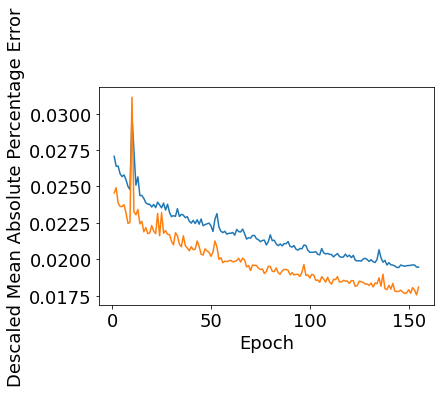

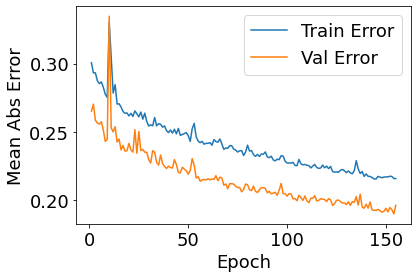

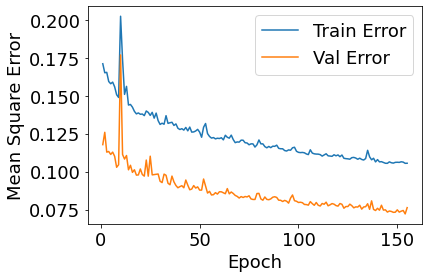

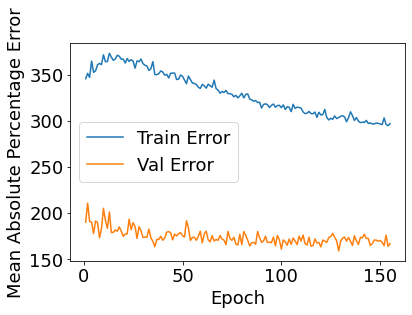

In [57]:
def plot_history(history):
  hist = pd.DataFrame(history)
  hist['epoch'] = np.arange(1,len(hist)+1) #history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Descaled Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['descaled_mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_descaled_mape'],
           label = 'Val Error')
#   plt.ylim([0.9,
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [77]:
temp_df_15_filled = temp_df_15_filled.asfreq(freq="1D")

In [78]:
gaps = gap_loc_and_len(temp_df_15_filled.TEMP.values)
gaps

,location,length
0,114,40
1,337,91
2,1216,45
3,1710,88
4,1891,181
5,2095,67
6,2209,40


In [129]:
# load temp_df_15_filled
pickle_in = open("../data/temp_df_15_filled.pickle", "rb")
temp_df_15_filled = pickle.load(pickle_in)
pickle_in.close()

In [161]:
def recursive_gapfill(sample, lstm_model, train_mean, train_std):
    """
    Function to fill gaps in a timeseries with a LSTM RNN model
    Args:
        sample: A numpy array of timeseries with gaps represented by NaNs
        lstm_model: A model trained on the entire sample dataset for gap-filling
        train_mean: the mean value to de(re)scale model output with
        train_std: sd to de(re)scale model output with
    """
    
    while np.any(np.isnan(sample)):
        # find the first NaN
        gap_start = np.min(np.argwhere(np.isnan(sample))) 
        if gap_start < 30:
            print('Error: There must be atleast 30 non nan values before the first gap for the prediction to work.')
            break
        else:
            # find gap length
            gap_length = np.min(np.argwhere(~np.isnan(sample[gap_start:])))
            if gap_length > 10:
                gap_length = 10
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(sample[:gap_start][-30:], (1,30,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = bidirectional_lstm_targ10_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            sample[gap_start : (gap_start + gap_length)] = out
        
    return sample

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Text(0.02, 0.9, '(b)')

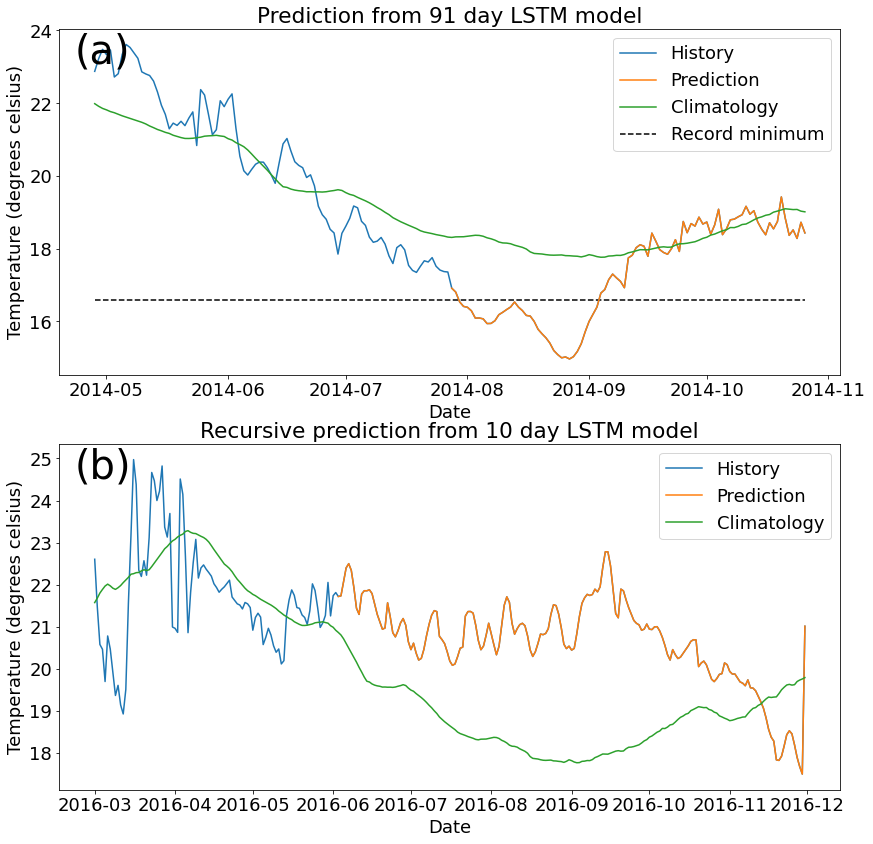

In [182]:
# load model2 if not already loaded
# load train_mean and train_std first
pickle_in = open("../data/train_mean-std_train-val_data-labels_hist91_targ91.pickle", "rb")
data = pickle.load(pickle_in)
train_mean = data[0]
train_std = data[1]
pickle_in.close()
bidirectional_lstm_targ91_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist91_targ91_loss-descaledmape_Earlystopping.h5', compile=False)
bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

# sample comparisons with climatology
sample = temp_df_15_filled.copy()
# sample = temp_df_15_filled.asfreq('1D')
hist = sample[(1216-91):(1216+91)]
pred = gapfill(hist, bidirectional_lstm_targ91_model, train_mean, train_std, 91, 91)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14,14))
axes[0].plot(hist.index, hist.TEMP, label = "History")
axes[0].plot(pred[91:].index, pred[91:].TEMP, label = "Prediction")
axes[0].plot(hist.index, clim.loc[hist.index.dayofyear], label = "Climatology")
axes[0].hlines(temp_df_15.TEMP.min(), xmin=hist.index[0], xmax=hist.index[-1], linestyles='dashed', label = "Record minimum")
axes[0].legend()
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Temperature (degrees celsius)")
axes[0].set_title("Prediction from 91 day LSTM model")
axes[0].text(0.02,0.9, "(a)", transform=axes[0].transAxes, fontsize=40)

# load model 1
# load train_mean and train_std first
pickle_in = open("../data/train_mean-std_train-val_data-labels_hist30_targ10.pickle", "rb")
data = pickle.load(pickle_in)
train_mean = data[0]
train_std = data[1]
pickle_in.close()
bidirectional_lstm_targ10_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ10_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ10_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

# create a similar plot for 181 day gap
hist = temp_df_15_filled.copy()
hist = hist[(1798):(1891+182)]
# use recursive gapfilling to fill the 181 day gap with the 10 day model
pred = recursive_gapfill(hist.TEMP.values, bidirectional_lstm_targ10_model, train_mean, train_std)
axes[1].plot(hist.index, hist.TEMP, label = "History")
axes[1].plot(hist[-181:].index, pred[-181:], label = "Prediction")
axes[1].plot(hist.index, clim.loc[hist.index.dayofyear], label = "Climatology")
# axes[1].hlines(temp_df_15.TEMP.min(), xmin=hist.index[0], xmax=hist.index[-1], linestyles='dashed', label = "Record minimum")
axes[1].legend()
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Temperature (degrees celsius)")
axes[1].set_title("Recursive prediction from 10 day LSTM model")
axes[1].text(0.02,0.9, "(b)", transform=axes[1].transAxes, fontsize=40)

In [113]:
history = np.reshape(temp_df_15_filled.TEMP.values[:1710][-91:], (1,91,1))
history = (history - train_mean)/train_std
pred = bidirectional_lstm_targ91_model.predict(history)[0,]
pred = pred * train_std + train_mean

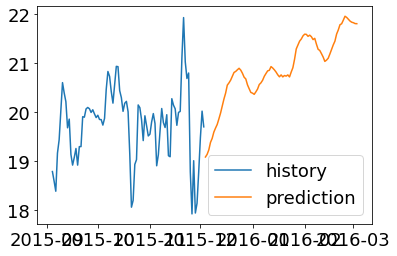

In [114]:
plt.plot(temp_df_15_filled.index[:1710][-91:], temp_df_15_filled[:1710][-91:], label = "history")
plt.plot(temp_df_15_filled.index[1710:(1710+91)], pred, label = "prediction")
plt.legend()

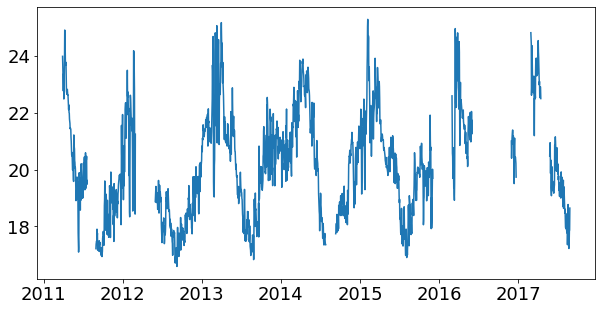

In [93]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled.index, temp_df_15_filled.TEMP)

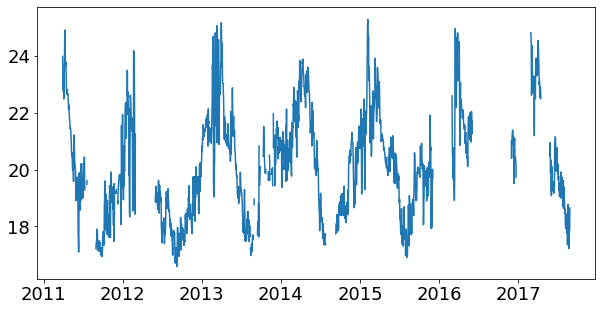

In [80]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_wgaps.index, temp_df_15_wgaps.TEMP)

In [115]:
def gapfill(samp, lstm_model, train_mean, train_std):
    gaps = gap_loc_and_len(samp.TEMP)
    for i in range(len(gaps)):
        gap_start = gaps.location[i]
        gap_length = gaps.length[i]
        hist_end = gap_start
        if gap_start < 91:
            hist_start = 0
        else:
            hist_start = gap_start - 91
        if ((gap_start >= 91) and (not np.any(np.isnan(samp.TEMP[hist_start: hist_end]))) and (gap_length <= 91)):
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(samp.TEMP.values[:gap_start][-91:], (1,91,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = bidirectional_lstm_targ91_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            samp.TEMP[gap_start : (gap_start + gap_length)] = out
    return samp

In [116]:
temp_df_15_filled_2 = temp_df_15_filled.copy()
temp_df_15_filled_2 = gapfill(temp_df_15_filled_2, bidirectional_lstm_targ91_model, train_mean, train_std)

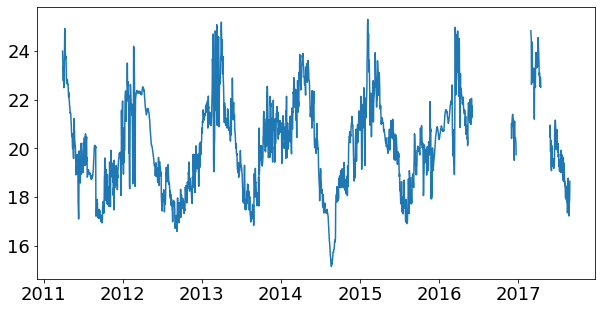

In [117]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled_2.index, temp_df_15_filled_2.TEMP)

In [88]:
gap_loc_and_len(temp_df_15_filled_2.TEMP)

,location,length
0,1891,181
1,2095,67
2,2209,40


In [101]:
# what does it look like when all gaps are recursively filled by this model?
def recursive_gapfill(sample, lstm_model, train_mean, train_std):
    """
    Function to fill gaps in a timeseries with a LSTM RNN model
    Args:
        sample: A numpy array of timeseries with gaps represented by NaNs
        lstm_model: A model trained on the entire sample dataset for gap-filling
        train_mean: the mean value to de(re)scale model output with
        train_std: sd to de(re)scale model output with
    """
    
    while np.any(np.isnan(sample)):
        # find the first NaN
        gap_start = np.min(np.argwhere(np.isnan(sample))) 
        if gap_start < 91:
            print('Error: There must be atleast 30 non nan values before the first gap for the prediction to work.')
            break
        else:
            # find gap length
            gap_length = np.min(np.argwhere(~np.isnan(sample[gap_start:])))
            if gap_length > 91:
                gap_length = 91
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(sample[:gap_start][-91:], (1,91,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = lstm_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            sample[gap_start : (gap_start + gap_length)] = out
        
    return sample

In [91]:
temp_df_15_filled_2 = temp_df_15_filled.copy()
temp_df_15_filled_2 = recursive_gapfill(temp_df_15_filled_2.TEMP.values, bidirectional_lstm_targ91_model, train_mean, train_std)

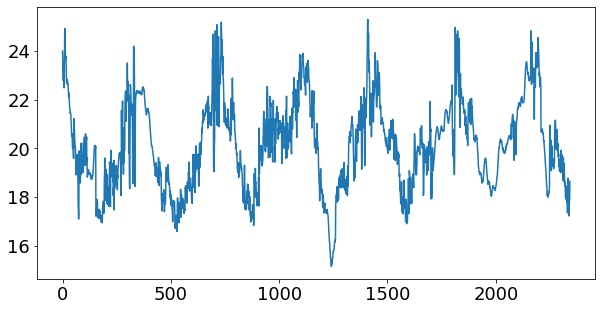

In [92]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled_2)

In [5]:
pickle_in = open("../data/temp_df_15_filled_2.pickle", "rb")
temp_df_15_filled_2 = pickle.load(pickle_in)
pickle_in.close()

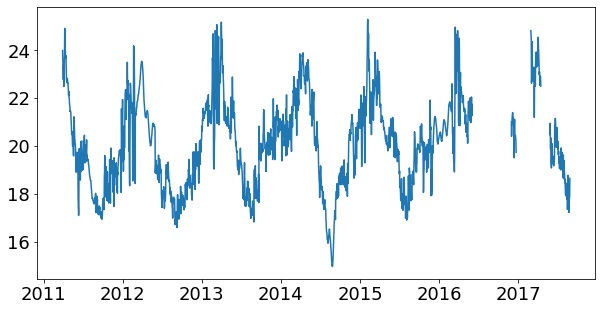

In [6]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled_2.index, temp_df_15_filled_2.TEMP)

In [7]:
# Training and validation data preparation
# Before we train model 3 we must remove the predicted gap at the end of July-2014 (index 1216) as it looks unreasonable.
temp_df_15_filled_2.TEMP[1216:(1216+45)] = np.nan # gap length is 45 days
# drop nans
temp_df_15_filled_2.dropna(inplace=True)

In [8]:
hist_len = 181
targ_len = 181
Time_diff = temp_df_15_filled_2.index.to_series().diff()
break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15_filled_2))
window_len = hist_len + targ_len

data = []
labels = []
break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15_filled_2.values[indices], (hist_len,1)))
        labels.append(temp_df_15_filled_2.values[i:i+targ_len])
data = np.array(data)
labels = np.array(labels)
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
train_labels = train_labels.reshape((len(train_labels),targ_len))
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)
val_labels = val_labels.reshape((len(val_labels), targ_len))
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()
# save training, validation and normalisation data
pickle_out = open("../data/train_mean-std_train-val_data-labels_hist181_targ181.pickle", "wb")
pickle.dump([train_mean, train_std, train_data, train_labels, val_data, val_labels], pickle_out)
pickle_out.close()
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

In [9]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    # Create a callback that saves the model's weights
# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [16]:
# Model 3 Training
BATCH_SIZE = 8
BUFFER_SIZE = train_data.shape[0]
train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
bidirectional_lstm_targ181_model = tf.keras.models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:])),
    layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True,)),
    layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')),
    tf.keras.layers.Dense(181)
])
bidirectional_lstm_targ181_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])
checkpoint_path = "../data/bidirectional_lstm_daily_hist181_targ181_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)    
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

# Model 3 training
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 100
history = bidirectional_lstm_targ181_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot()])

loss:  0.1363, val_loss:  0.0632
..........loss:  0.0465, val_loss:  0.0473
..........loss:  0.0522, val_loss:  0.0518
..........loss:  0.0431, val_loss:  0.0433
..........loss:  0.0402, val_loss:  0.0410
..........loss:  0.0382, val_loss:  0.0381
..........loss:  0.0370, val_loss:  0.0375
..........loss:  0.0367, val_loss:  0.0368
..........loss:  0.0356, val_loss:  0.0353
..........loss:  0.0342, val_loss:  0.0342
..........

In [17]:
pd.DataFrame(history.history)

,loss,descaled_mape,mae,mse,mean_absolute_percentage_error,val_loss,val_descaled_mape,val_mae,val_mse,val_mean_absolute_percentage_error
0,0.136302,0.136302,1.522267,5.549454e+01,3.571871e+02,0.063162,0.063162,0.691799,0.747371,131.822495
1,0.058590,0.058590,0.651004,6.850675e-01,1.724498e+02,0.056563,0.056563,0.620919,0.618455,188.110916
2,0.054686,0.054686,0.607632,6.028141e-01,2.029212e+02,0.054857,0.054857,0.602234,0.581001,199.423416
3,0.051760,0.051760,0.575314,5.431510e-01,2.202704e+02,0.052000,0.052000,0.573178,0.528512,217.092621
4,503.130280,503.130280,5269.943848,3.852801e+10,5.796951e+06,0.112386,0.112386,1.210996,5.657339,919.386353
...,...,...,...,...,...,...,...,...,...,...
95,0.033065,0.033065,0.369197,2.412698e-01,2.164676e+02,0.033340,0.033340,0.369544,0.237521,219.817871
96,0.032953,0.032953,0.368049,2.396338e-01,2.110235e+02,0.033232,0.033232,0.368219,0.235260,222.643173
97,0.032755,0.032755,0.365890,2.370187e-01,2.094104e+02,0.033002,0.033002,0.365935,0.233392,211.504807
98,0.032713,0.032713,0.365510,2.373149e-01,2.074864e+02,0.032858,0.032858,0.364218,0.231386,208.163055


In [19]:
## Save model
bidirectional_lstm_targ181_model.save('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist181_targ181_loss-descaledmape_100Epochs.h5')
## Save History
import pickle
pickle_out = open("../data/temp_gapfilling_daily_bidirectional_lstm_model_hist181_targ181_loss-descaledmape_100Epochs_history.pickle", "wb")
pickle.dump(pd.DataFrame(history.history), pickle_out)
pickle_out.close()

In [23]:
temp_df_15_filled_3 = temp_df_15_filled_2.copy()

In [24]:
temp_df_15_filled_3 = temp_df_15_filled_3.asfreq('1D')

In [27]:
gaps = gap_loc_and_len(temp_df_15_filled_3.TEMP)
gaps

,location,length
0,1216,45
1,1891,181
2,2095,67
3,2209,40


In [29]:
# Use model 3 to fill the first two gaps only
gaps = gaps[:2]

In [44]:
def gapfill(samp, lstm_model, train_mean, train_std, hist_len, pred_len, gaps = pd.DataFrame()):
    if gaps.empty: gaps = gap_loc_and_len(samp.TEMP)
    for i in range(len(gaps)):
        gap_start = gaps.location[i]
        gap_length = gaps.length[i]
        hist_end = gap_start
        if gap_start < hist_len:
            hist_start = 0
        else:
            hist_start = gap_start - hist_len
        if ((gap_start >= hist_len) and (not np.any(np.isnan(samp.TEMP[hist_start: hist_end]))) and (gap_length <= pred_len)):
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(samp.TEMP.values[:gap_start][-hist_len:], (1,hist_len,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = lstm_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            samp.TEMP[gap_start : (gap_start + gap_length)] = out
    return samp

In [45]:
temp_df_15_filled_3 = gapfill(temp_df_15_filled_3, bidirectional_lstm_targ181_model, train_mean, train_std, 181, 181, gaps = gaps)

In [47]:
gap_loc_and_len(temp_df_15_filled_3.TEMP)

,location,length
0,2095,67
1,2209,40


In [49]:
#load model2 to fill remaining gaps
bidirectional_lstm_targ91_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist91_targ91_loss-descaledmape_Earlystopping.h5', compile=False)
bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

In [50]:
temp_df_15_filled_3 = gapfill(temp_df_15_filled_3, bidirectional_lstm_targ91_model, train_mean, train_std, 91, 91)

In [51]:
gap_loc_and_len(temp_df_15_filled_3.TEMP)

,location,length


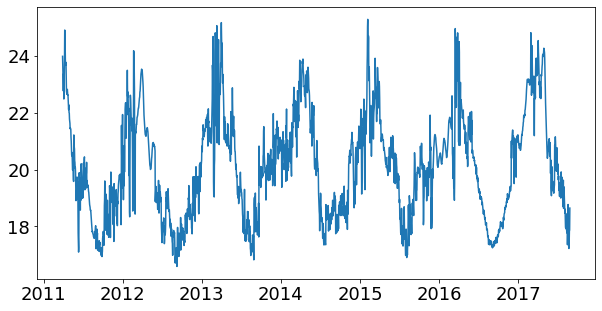

In [52]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled_3.index, temp_df_15_filled_3.TEMP)

In [53]:
# Save Model 3 filled ts
pickle_out = open("../data/temp_df_15_filled_3.pickle", "wb")
pickle.dump(temp_df_15_filled_3, pickle_out)
pickle_out.close()


## Recursive gap-filling and filled gap visualisation

In [102]:
def recursive_gapfill(sample, lstm_model, train_mean, train_std):
    """
    Function to fill gaps in a timeseries with a LSTM RNN model
    Args:
        sample: A numpy array of timeseries with gaps represented by NaNs
        lstm_model: A model trained on the entire sample dataset for gap-filling
        train_mean: the mean value to de(re)scale model output with
        train_std: sd to de(re)scale model output with
    """
    
    while np.any(np.isnan(sample)):
        # find the first NaN
        gap_start = np.min(np.argwhere(np.isnan(sample))) 
        if gap_start < 30:
            print('Error: There must be atleast 30 non nan values before the first gap for the prediction to work.')
            break
        else:
            # find gap length
            gap_length = np.min(np.argwhere(~np.isnan(sample[gap_start:])))
            if gap_length > 10:
                gap_length = 10
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(sample[:gap_start][-30:], (1,30,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = bidirectional_lstm_targ10_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            sample[gap_start : (gap_start + gap_length)] = out
        
    return sample

### Compare with interpolation

In [80]:
temp_df_15 = temp_df_15.asfreq(freq='1D')

In [81]:
# Use interpolateTime to fill nans
temp_df_15 = temp_df_15.assign(InterpTime = temp_df_15.TEMP.interpolate(method='time'))

In [83]:
# load tri-model predicted (filled) timeseries
pickle_in = open("../data/temp_df_15_filled_3.pickle", "rb")
temp_df_15_filled = pickle.load(pickle_in)
pickle_in.close()

In [84]:
# add to original ts temp_df_15 as another column
temp_df_15 = temp_df_15.assign(LSTM_prediction = temp_df_15_filled.TEMP) 

In [85]:
temp_df_15

,TEMP,InterpTime,LSTM_prediction
TIME,,,
2011-03-30,23.995378,23.995378,23.995378
2011-03-31,23.710236,23.710236,23.710236
2011-04-01,23.333200,23.333200,23.333200
2011-04-02,22.781210,22.781210,22.781210
2011-04-03,22.811733,22.811733,22.811733
...,...,...,...
2017-08-23,17.224247,17.224247,17.224247
2017-08-24,17.473562,17.473562,17.473562
2017-08-25,17.870966,17.870966,17.870966


In [86]:
# remove predictions where there are no nans
temp_df_15.InterpTime.iloc[np.where(~np.isnan(temp_df_15.TEMP))] = np.nan
temp_df_15.LSTM_prediction.iloc[np.where(~np.isnan(temp_df_15.TEMP))] = np.nan

In [87]:
def gapfilling_comp_plot(plot_df):
  plt.figure(figsize=(12, 6))

  plt.plot(plot_df.index, plot_df.TEMP, label='Gappy timeseries')
  plt.plot(plot_df.index, plot_df.InterpTime,
           label='Interpolated')
  plt.plot(plot_df.index, plot_df.LSTM_prediction,
            label='LSTM predicted')
  plt.legend(loc='upper left')
  plt.ylabel("Temperature (degree celsius)")
  plt.xlabel("Time (years)")
  plt.show()

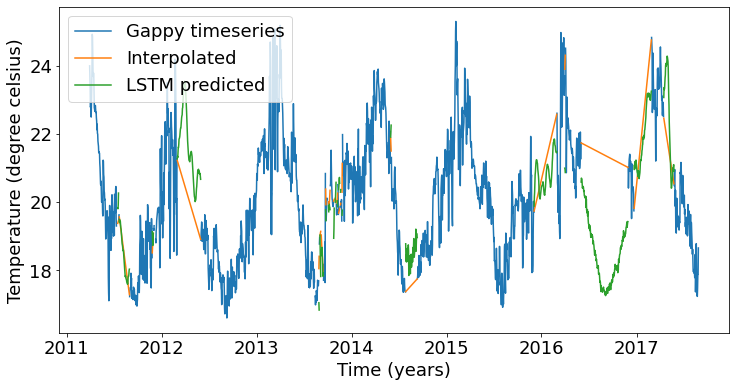

In [88]:
gapfilling_comp_plot(temp_df_15)

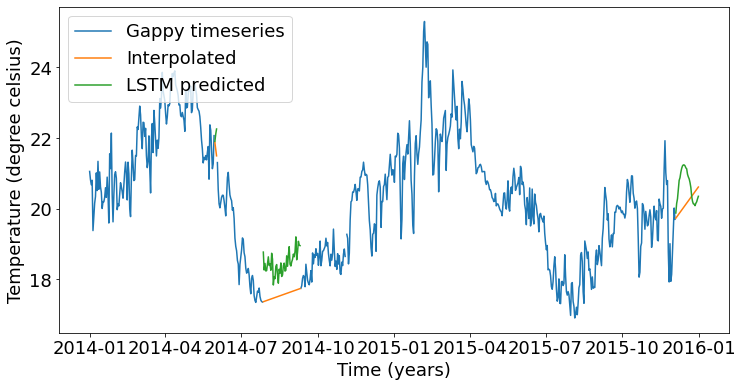

In [89]:
gapfilling_comp_plot(temp_df_15[(temp_df_15.index.year >= 2014) & (temp_df_15.index.year <= 2015)])